# Lab1: Binary image classifier

Author: Ryan Baker

## 1. Setup
Install fastbook and setup Google drive connection.

In [22]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Import necessary libraries

In [23]:
from fastbook import *
from fastai.vision.widgets import *

## 2. Download images 
Use Azure image search or DuckDuckGo to download 150 images of each class. Save images to Google drive.

In [24]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')

guitar_types = 'acoustic', 'electric'
path = export_path/'guitars_ddg/'

if not path.exists():
  path.mkdir()
for o in guitar_types:
  dest = (path/o)
  dest.mkdir(exist_ok=True)
  results = search_images_ddg(f'{o} guitar', max_images=150)
  download_images(dest, urls=results)



### 2.1 Try it out
Similar to the lecture notebook, try out your query and plot a few of the resulting images to verify that your search returns sensible images.

0: https://c1.zzounds.com/media/fit,2018by3200/quality,85/7_Body_Left_Front_NA-ac355339f9502c6a927166adc63bb965.jpg
1: https://www.scmusic.com.au/content/uploads/2013/10/cort-ad810-OPEN-PORE-south-coast-music.jpg
2: https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/7_Body_Left_Front_NA-a00e0eaa0a4682d86c193318aa13cb66.jpg
3: https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/7_Body_Left_Front_NA-36997a033a4005149a03499aa004af13.jpg
4: https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/7_Body_Left_Front_NA-d57faa94b091238e4e70390d1ae2a358.jpg
5: http://urguitars.com/wp-content/uploads/2016/04/GD51CE-NAT.jpeg
6: https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/1_Full_Straight_Front_NA-cde97ad23bbc4dcfe17b7f18bbd8890a.jpg
7: https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/1_Full_Straight_Front_NA-30baa8f39ab097c277cebec96f67a72f.jpg
8: http://wallpapercave.com/wp/KzeFrdK.jpg
9: https://www.long-mcqu

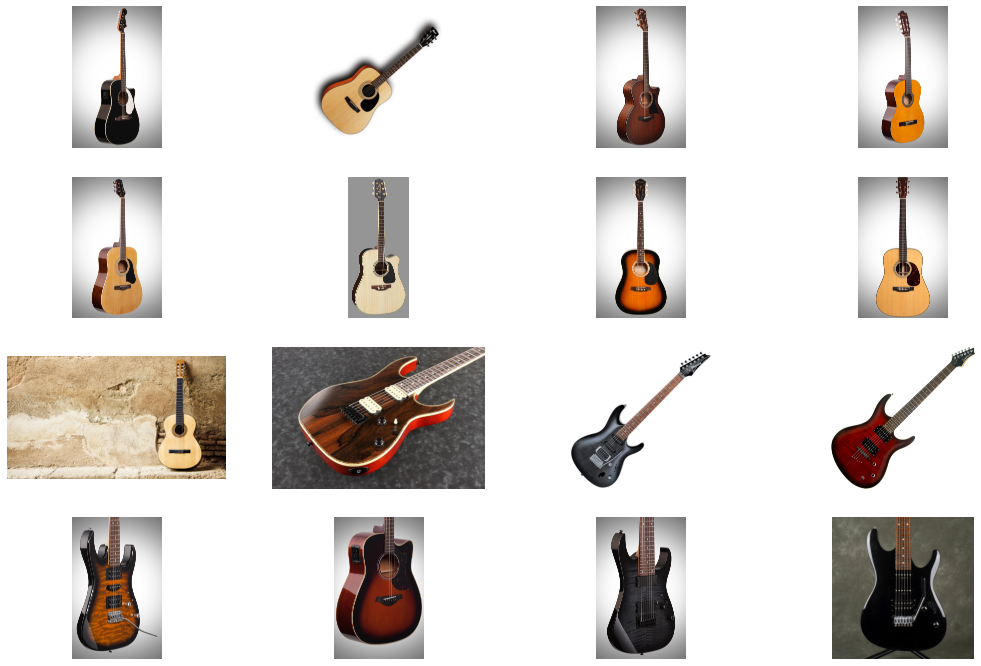

In [30]:
urls = search_images_ddg('acoustic_guitar', max_images=8)[0:9] + search_images_ddg('electric guitar', max_images=8)[0:9]
f, axes = plt.subplots(4, 4, figsize=(18,12))
axes = axes.flatten()
ax_i = 0
img_i = 0
while ax_i < len(axes) and img_i < len(urls):
    try:
      url = urls[img_i]
      print(f'{img_i}: {url}')
      image_data = requests.get(url)
      image_data.raise_for_status()
      
      image = Image.open(BytesIO(image_data.content)) 
      axes[ax_i].imshow(image)
      axes[ax_i].axis("off")
      ax_i += 1 # next axis
    except requests.exceptions.RequestException as e:
      print(e)
    finally:
      img_i += 1 # next image, especially when exception occured

      
plt.show()

### 2.2 Get images for the two classes
Download 150 images of each class. Save images to Google drive.  
Remove any corrupt images using `verify_images()`.

In [34]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')

guitar_types = 'acoustic', 'electric'
path = export_path/'guitars_ddg'

if not path.exists():
  path.mkdir()
for o in guitar_types:
  dest = (path/o)
  dest.mkdir(exist_ok=True)
  results = search_images_ddg(f'{o} guitar', max_images=150)
  download_images(dest, urls=results)
  fns = get_image_files(dest)
  failed = verify_images(fns)
  failed.map(Path.unlink)



## 3. Setup image loaders
Setup image loaders, use 20% of images for validation, and show one batch for each training and validation dataset.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


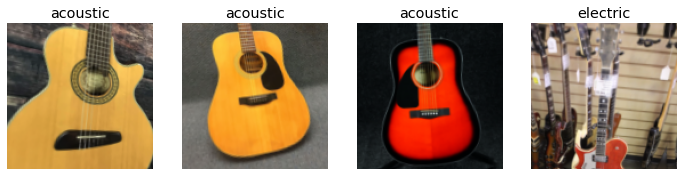

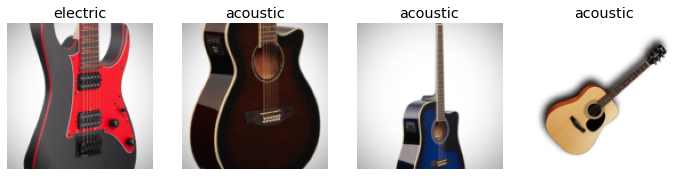

In [43]:
guitars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(128))

guitars = guitars.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1))
dls = guitars.dataloaders(path)

dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

**Question 1:** How many images of each class are in trainging and validation sets?

*Approximately 130 images of each class are in the training set, and approximately 20 images of each class are in the validation set.*

NOTE: `search_images_ddg(f'{o} guitar', max_images=150)` only gives an approximation for `max_images`, so there are likely more than just 150 images of each class.

## 4. Setup cnn learner
Setup a cnn learner with the dataloaders, `resnet18` architecture and `error_rate` as metric.

In [44]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 5. Train binary classifier
Fine tune for 10 epochs and show results.

epoch,train_loss,valid_loss,error_rate,time
0,1.197805,0.669236,0.207792,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.714109,0.483511,0.168831,00:37
1,0.647545,0.366644,0.116883,00:34
2,0.575421,0.377132,0.103896,00:35
3,0.516065,0.484901,0.129870,00:35
4,0.480457,0.496378,0.116883,00:35
5,0.436104,0.469953,0.103896,00:34
6,0.414522,0.438163,0.090909,00:35
7,0.398687,0.437059,0.116883,00:35
8,0.384079,0.443159,0.116883,00:35
9,0.379115,0.437659,0.116883,00:35


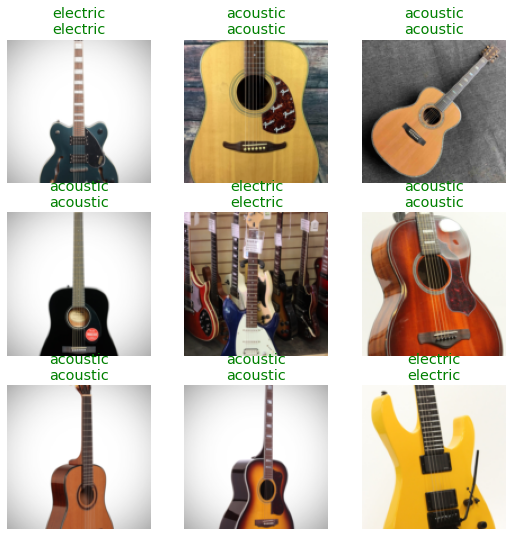

In [45]:
learn.fine_tune(10)
learn.show_results()

**Question 2:** Is the model overfitting? Why, why not?

*The validation loss decreases at epoch 1, increases at epochs 2, 3, and 4, then decreases through to epoch 9. Because the validation loss was lowest at epoch 1, the model appears to be overfitting.*

## 6. Analyze results

Plot confusion matrix.

Plot top 5 losses.


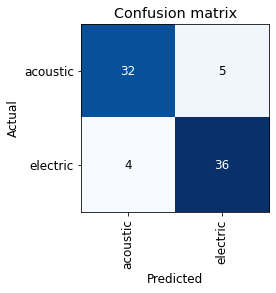

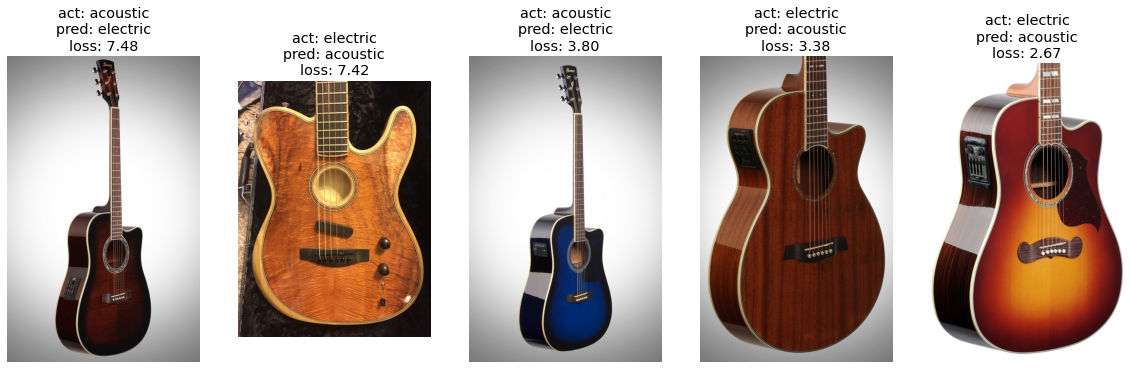

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

k=5
losses, idxs = interp.top_losses(k)
predicteds = interp.preds[idxs].argmax(axis=1)
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(20, 10))

for ax, id, loss, pred in zip(axs, idxs, losses, predicteds):
    img, actual = dls.valid_ds[id]
    img.show(ctx=ax)
    ax.set_title(f'act: {dls.vocab[actual.item()]}\npred: {dls.vocab[pred]}\nloss: {loss:.2f}')

**Question 3:** How many false positive, false negative errors?

*There were 5 false positive and 4 true negative errors.*

## 7. Summary and Conclusion

Summarize:
- Type of classifier trained.
- Number of images of each class in the training validation sets
- Error rate achieved

*YOUR ANSWER HERE*
- Convolutional neural network
- Electric training set: ~130 images
- Electric validation set: ~20 images
- Acoustic training set: ~130 images
- Acoustic validation set: ~20 images
- Error rate: 0.116883

Conclusion:
- Are there any problems with data/labeling?
- Are you satisfied with model performance? Why, why not?

*YOUR ANSWER HERE*
- There were some notable problems with datalabeling. Looking at the top 5 losses, 4 of them could be classified as electric-acoustic (ie. they have have electric pickups but also have an acoustic body). If all of these images would be classified consistently, the model would likely have much lower validation loss (since similar features would be categorized consistently).
- I am personally satisfied with the model's performance, because it was given some rough data, yet only had an error rate of 11.6%.

## 8. Reflection
Include a sentence or two about 
- what you liked or disliked, 
- found interesting, confusing, challangeing, motivating 

while working on this assignment.

*YOUR ANSWER HERE*
- Personally enjoyed learning how to implement a fill deep learning model from start to finish!
- I found some of the syntax a bit different from last semester's traditional artificial intelligence models, but it was still intuitive. The FastAI documentation is really good!